<a href="https://colab.research.google.com/github/LakshmiThirunavukkarasu/Computer-Vision/blob/main/Face_Detection_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install facenet_pytorch

**Collect Faces from lfw dataset**

In [ ]:
import os
import shutil

DATA_DIR = os.path.join("/content", "FaceRec-Dataset")
TEST_DATA_DIR = os.path.join(os.path.join("/content", "FaceRec-Dataset"),'Test')
TRAIN_DATA_DIR = os.path.join(os.path.join("/content", "FaceRec-Dataset"),'Train')

if os.path.exists(TRAIN_DATA_DIR) and os.path.isdir(TRAIN_DATA_DIR):
  shutil.rmtree(TRAIN_DATA_DIR)

if os.path.exists(TRAIN_DATA_DIR + "_cropped") and os.path.isdir(TRAIN_DATA_DIR + "_cropped"):
  shutil.rmtree(TRAIN_DATA_DIR + "_cropped")

if os.path.exists(TEST_DATA_DIR) and os.path.isdir(TEST_DATA_DIR):
  shutil.rmtree(TEST_DATA_DIR)

if os.path.exists(DATA_DIR) and os.path.isdir(DATA_DIR):
  shutil.rmtree(DATA_DIR)

In [ ]:
!mkdir "/content/FaceRec-Dataset"
!mkdir "/content/FaceRec-Dataset/Train"
!mkdir "/content/FaceRec-Dataset/Test"

In [ ]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

total_count = len(lfw_people.images)
print(total_count)

classes = {}
for i in range(len(lfw_people.target_names)):
  classes[i] = lfw_people.target_names[i]

train_idx  = 0
test_idx = 0
img_idx = 0

for i in range(len(lfw_people.images)):
  print("iteration ", i)
  img = Image.fromarray(lfw_people.images[i])
  img = img.convert("RGB")
  
  if test_idx == 1:
    path = os.path.join(TEST_DATA_DIR, classes[lfw_people.target[i]])
    test_idx = test_idx + 1
  else:
    path = os.path.join(TRAIN_DATA_DIR, classes[lfw_people.target[i]])
  

  if  not os.path.exists(path):
    os.mkdir(path)

  print(os.path.join(path, "img" + str(img_idx) + ".jpg"))
  img.save(os.path.join(path, "img" + str(img_idx) + ".jpg"))
  img_idx = img_idx + 1
  
  if train_idx == 500:
    test_idx = 1
  else:
    train_idx = train_idx + 1

  if test_idx == 100:
    break   

1288
iteration  0
/content/FaceRec-Dataset/Train/Hugo Chavez/img0.jpg
iteration  1
/content/FaceRec-Dataset/Train/Tony Blair/img1.jpg
iteration  2
/content/FaceRec-Dataset/Train/George W Bush/img2.jpg
iteration  3
/content/FaceRec-Dataset/Train/Colin Powell/img3.jpg
iteration  4
/content/FaceRec-Dataset/Train/Ariel Sharon/img4.jpg
iteration  5
/content/FaceRec-Dataset/Train/Colin Powell/img5.jpg
iteration  6
/content/FaceRec-Dataset/Train/George W Bush/img6.jpg
iteration  7
/content/FaceRec-Dataset/Train/Gerhard Schroeder/img7.jpg
iteration  8
/content/FaceRec-Dataset/Train/George W Bush/img8.jpg
iteration  9
/content/FaceRec-Dataset/Train/Ariel Sharon/img9.jpg
iteration  10
/content/FaceRec-Dataset/Train/George W Bush/img10.jpg
iteration  11
/content/FaceRec-Dataset/Train/Donald Rumsfeld/img11.jpg
iteration  12
/content/FaceRec-Dataset/Train/George W Bush/img12.jpg
iteration  13
/content/FaceRec-Dataset/Train/Colin Powell/img13.jpg
iteration  14
/content/FaceRec-Dataset/Train/Gerhard 

**Load the Libaries**

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import numpy as np
import os

**Configuration**

In [ ]:
batch_size = 16
epochs = 15
workers = 0 if os.name == 'nt' else 8

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


**Face Detection using MTCNN**

In [ ]:
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device=device,
    selection_method='center_weighted_size'
)

In [ ]:
# Define the data loader for the input set of images
orig_img_ds = datasets.ImageFolder(TRAIN_DATA_DIR, transform=[transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor()])

In [ ]:
# overwrites class labels in dataset with path so path can be used for saving output in mtcnn batches
orig_img_ds.samples = [
    (p, p)
    for p, _ in orig_img_ds.samples
]

loader = DataLoader(
    orig_img_ds,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
crop_paths = []
box_probs = []

for i, (x, b_paths) in enumerate(loader):
    crops = [p.replace(TRAIN_DATA_DIR, TRAIN_DATA_DIR + '_cropped') for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

Batch 32 of 32

In [ ]:
# Remove mtcnn to reduce GPU memory usage
del mtcnn
torch.cuda.empty_cache()

**Face Alignment**

In [ ]:
# create dataset and data loaders from cropped images output from MTCNN

trans = transforms.Compose([
    np.float32,
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(TRAIN_DATA_DIR + '_cropped', transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Feature Extraction: Extract Face embeddings using pretrained Resnet Model**

In [ ]:
# Load pretrained resnet model
resnet = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device)

**Dictionary of Face Embeddings**

In [ ]:
classes = []
embeddings = []
resnet.eval()
with torch.no_grad():
    for xb, yb in embed_loader:
        xb = xb.to(device)
        b_embeddings = resnet(xb)
        b_embeddings = b_embeddings.to('cpu').numpy()
        classes.extend(yb.numpy())
        embeddings.extend(b_embeddings)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
embeddings_dict = dict(zip(crop_paths,embeddings))

**Feature Matching based on Cosine similarity of the embeddings**

In [ ]:
from sklearn.model_selection import KFold
from scipy import interpolate

# LFW functions taken from David Sandberg's FaceNet implementation
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=2, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=2, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean

def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    if n_same == 0:  n_same = 0.001
    if n_diff == 0:  n_diff = 0.001
    #if true_accept == 0:  true_accept = 0.001
    #if false_accept == 0:  false_accept = 0.001

    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)

    return val, far



def evaluate(embeddings, actual_issame, nrof_folds=3, distance_metric=0, subtract_mean=False):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    #print(embeddings1)
    embeddings2 = embeddings[1::2]
    #print(embeddings2)
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn

def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

def get_paths(lfw_dir, pairs):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], 'img' + '%03d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[0], 'img' + '%03d' % int(pair[2])))
            issame = True
        elif len(pair) == 4:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], 'img' + '%03d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[2], 'img' + '%03d' % int(pair[3])))
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)


    return path_list, issame_list



**Create Face Pair for Matching**

In [ ]:
pairs = []
pairs.append(['Ariel Sharon', '111', '137'])
pairs.append(['Colin Powell', '115', '224'])
pairs.append(['Donald Rumsfeld', '159', '267'])
pairs.append(['George W Bush', '100', '123'])
pairs.append(['Ariel Sharon', '111', 'Colin Powell', '186'])
pairs.append(['Ariel Sharon', '195', 'George W Bush', '109'])
pairs.append(['Donald Rumsfeld', '165', 'George W Bush', '109'])


path_list, issame_list = get_paths(TRAIN_DATA_DIR+'_cropped', pairs)
embeddings = np.array([embeddings_dict[path] for path in path_list])
print(issame_list)


[True, True, True, True, False, False, False]


In [ ]:
tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings, issame_list)

**Performance Report**

In [ ]:
print("True Positive Rate:", np.mean(tpr))
print("False Positive Rate:", np.mean(fpr))
print("Accurancy:", np.mean(accuracy))

True Positive Rate: 0.5213888888888889
False Positive Rate: 0.42791666666666656
Accurancy: 0.3333333333333333


**Import the Libraries**

In [ ]:
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()
print(torch_home)

/root/.cache/torch


In [ ]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


**Load Dataset**

In [ ]:
print(TEST_DATA_DIR)

/content/FaceRec-Dataset/Test


In [ ]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [ ]:
img = cv2.imread("/content/FaceRec-Dataset/Test/Tony Blair/img114.jpg")
print(img.shape)
x =mtcnn(img)
print("---")
print(type(x))

(50, 37, 3)
---
<class 'NoneType'>


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class."""
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize

    def __call__(self, dir):
        print("inside call function")
        """Load frames from an MP4 video and detect faces."""
        import matplotlib.pyplot as plt
        images = []
        faces = []
        for sub_dir in os.listdir(dir):
          print(dir)
          for file in os.listdir(os.path.join(dir, sub_dir)):
              imagefile = os.path.join(os.path.join(dir, sub_dir), file)
              print(imagefile)
              image = Image.open(imagefile)
              #image = Image.fromarray(image)
              #image = image.convert('RGB')
              #image = cv2.imread(imagefile)
              #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              #plt.imshow(image)
              #image = Image.fromarray(image)
             
              #Resize frame to desired size
              if self.resize is not None:
                    image = image.resize([int(d * self.resize) for d in image.size])
              images.append(image)
              print(image.size)

              print("length", len(images))
              # When batch is full, detect faces and reset frame list
              if len(images) % self.batch_size == 0:
                frames = []
              else:
                 #faces.extend(self.detector(image))
                 x =  mtcnn(image)
                 print(x)
            

              #faces.extend(self.detector(images))

        return faces

def process_faces(faces, resnet):
      # Filter out frames without faces
      faces = [f for f in faces if f is not None]
      faces = torch.cat(faces).to(device)

      # Generate facial feature vectors using a pretrained model
      embeddings = resnet(faces)

      # Calculate centroid for video and distance of each face's feature vector from centroid
      centroid = embeddings.mean(dim=0)
      x = (embeddings - centroid).norm(dim=1).cpu().numpy()
    
      return x

In [ ]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=10, resize=0.25)


In [ ]:
DEVICE = 'cuda'

BATCH_SIZE = 10
NUM_WORKER = 4
LR = 0.001
EPOCHS = 20

Inference

In [ ]:
print(TEST_DATA_DIR)
faces = detection_pipeline(TEST_DATA_DIR )

#https://morioh.com/p/815e930f5e8d

/content/FaceRec-Dataset/Test
inside call function
/content/FaceRec-Dataset/Test
/content/FaceRec-Dataset/Test/George W Bush/img113.jpg
(9, 12)
length 1


NotImplementedError: ignored

In [ ]:
# Calculate embeddings
X = []
X.append(process_faces(faces, resnet))

NameError: ignored

**Configurations**

**Import LIbraries**

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1
import imutils
import cv2

In [ ]:
!mkdir "/content/FaceRec-Dataset"
!mkdir "/content/FaceRec-Dataset/Cropped"

mkdir: cannot create directory ‘/content/FaceRec-Dataset’: File exists
mkdir: cannot create directory ‘/content/FaceRec-Dataset/Cropped’: File exists


Create Dataset

**Face Detection using MTCNN**

In [ ]:
mtcnn = MTCNN(margin= 40)
DATA_DIR = '/content/FaceRec-Dataset/Test'

In [ ]:
dir(detector)

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid 

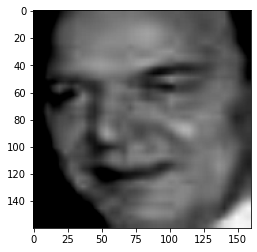

In [ ]:
for dir in os.listdir(DATA_DIR):
    for file in os.listdir(os.path.join(DATA_DIR, dir)):
        image = os.path.join(os.path.join(DATA_DIR, dir), file)
        if os.path.isfile(image):
            #savepath = os.path.join(os.path.join(CROPPED_DATA_DIR, dir), file)
            #print("Save path ", savepath)
            img = ""
            img = Image.open(image)
            

            ## Get cropped and prewhitened image tensor
            #img_cropped, probs = mtcnn(img , save_path = savepath, return_prob=True)
            img_cropped = mtcnn(img)
            if img_cropped is not None:
              plt.imshow(img_cropped.permute(1,2,0))

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2',classify=False,num_classes=len(classes)).eval()
img_embedding = resnet(img)

TypeError: ignored

In [ ]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
import numpy as np
# Calculate embedding (unsqueeze to add batch dimension)
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet
name_list = [] # list of names corrospoing to cropped photos

resnet = InceptionResnetV1(pretrained='vggface2').eval()
for dir in os.listdir(DATA_DIR):
    for file in os.listdir(os.path.join(DATA_DIR, dir)):
        file_name = os.path.join(os.path.join(DATA_DIR, dir), file)
        if os.path.isfile(file_name):
            img = np.asarray(Image.open(file_name).convert('RGB'))
            #img = preprocess(img)
            img = img.unsqueeze(0)
            img_embedding = resnet(img)
            embedding_list.append(img_embedding.detach()) 
            name_list.append(dir)  

AttributeError: ignored

https://towardsdatascience.com/everything-about-fasterrcnn-6d758f5a6d79

In [ ]:
from torchvision import datasets, transforms as T
import albumentations as A 

In [ ]:
train_augs = A.Compose([
      A.Rotate(),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
])



In [ ]:
model_dataset = datasets.ImageFolder(root = DATA_DIR)


In [ ]:
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count

In [ ]:
import torch
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

In [ ]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKER)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(f"No. of batches in trainloader : {len(train_dataset_loader)}")
print(f"No. of batches in validloader : {len(valid_dataset_loader)}")
print(f"No. of batches in testloader : {len(test_dataset_loader)}")

No. of batches in trainloader : 57
No. of batches in validloader : 17
No. of batches in testloader : 9


In [ ]:
for images, labels in train_dataset_loader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

In [ ]:
import torch
import torchvision

import torchdatasets as td

data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

# Single change, makes an instance of torchdata.Dataset
# Works just like PyTorch's torch.utils.data.Dataset, but has
# additional capabilities like .map, cache etc., see project's description
model_dataset = td.datasets.WrapDataset(torchvision.datasets.ImageFolder(DATA_DIR))
# Also you shouldn't use transforms here but below
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    model_dataset, (train_count, valid_count, test_count)
)

# Apply torchvision mappings ONLY to train dataset
train_dataset.map(
    td.maps.To(
        torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(224),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.ToTensor(),
            ]
        )
    ),
    # Apply this transformation to zeroth sample
    # First sample is the label
    0,
)

# Rest of the code goes the same

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER
)
dataloaders = {
    "train": train_dataset_loader,
    "val": valid_dataset_loader,
    "test": test_dataset_loader,
}

AttributeError: ignored

In [ ]:
!pip install torchdatasets